## Environment Setup

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── Generate Radio Data for tr.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import multiprocessing as mp
import numpy as np

from radioml.models import Baseline
from radioml.metrics import get_ber_bler
from radioml.dataset import RadioDataGenerator

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Parameters

In [3]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 2

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Create a training generator / validation generator 

In [4]:
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')

training_generator   = radio.end2end_data_generator(OMEGA_TRAIN, 
                                                    SNR_TRAIN, 
                                                    batch_size=128, 
                                                    num_cpus=8)
validation_generator = radio.end2end_data_generator(OMEGA_TRAIN, 
                                                    SNR_TRAIN, 
                                                    batch_size=128, 
                                                    seed=2018)

## Modular Network Funcs (CFO, Equalization, Demod & ECC)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()

def cfo_network(preamble, preamble_conv, scope='CFONet'):
    """
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
        
    Return:
        cfo_estimate: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=1)
        inputs = tf.keras.layers.Flatten(name='Flatten')(inputs)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_1")(inputs)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_2")(x)
        x = tf.keras.layers.Dense(100, 'tanh', name=scope+"_dense_3")(x)
    cfo_est = tf.keras.layers.Dense(1, 'linear',name='CFOEstimate')(x)
    
    return cfo_est

def cfo_correction_func(kwargs):
    """Rotate packet given an omega estimate 
    
    Arguments:
    ----------
        omega_estimate: tf.Tensor float32 - [batch, 1]
        packets:        tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
    Returns:
    --------
        cfo_corrected_packets: tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
    """ 
    # Because of Lambda Layer, we need to pass arguments as Kwargs
    omega_estimate, packets = kwargs[0], kwargs[1]
    
    with tf.name_scope('rotation_matrix'):
        time_step_matrix= tf.range(tf.cast(tf.shape(packets)[1], dtype=tf.float32))
        power_term      = tf.complex(0.0, - omega_estimate * time_step_matrix)
        rotation_matrix = tf.exp(power_term)
    
    with tf.name_scope('cfo_correction'):
        rotated_packets = tf.complex(packets[..., 0], 
                                     packets[...,1]) * rotation_matrix
        
    cfo_corrected_packet = tf.stack([tf.real(rotated_packets), 
                                     tf.imag(rotated_packets)], 
                                    axis=-1)
    return cfo_corrected_packet

def channel_estimation_network(preamble, cfo_corrected_preamble, scope='ChannelEstimationNet'):
    """Channel Estimation."""
    with tf.name_scope('ChannelEstimationNet'):
        inputs = tf.keras.layers.concatenate([preamble, cfo_corrected_preamble], axis=-1,
                                            name='Preamble_CFOCorrectedPreamble')
        inputs = tf.keras.layers.Flatten()(inputs)
        x = Dense(300, 'relu', name='ChannelEstimationNet_Dense_1')(inputs)
        x = Dense(300, 'relu', name='ChannelEstimationNet_Dense_2')(x)
        x = Dense(CHANNEL_LEN, 'sigmoid', name='ChannelEstimate')(x)
    return x


def equalization_network(cfo_corrected_data, chan_est):
    """Given a [preamble, preambe_conv, data_conv] Predict equalized packet """
    
    chan_est = RepeatVector(DATA_LEN)(chan_est)
    inputs = tf.keras.layers.concatenate([cfo_corrected_data, chan_est], axis=-1,
                                        name="CFOCorrectedData_ChannelEstimate")
    with tf.name_scope('EqualizationNet'):
        scope='Equalizationnet'
        x = Bidirectional(LSTM(45, return_sequences=True), 
                          name=scope+'_BiLSTM_1')(inputs)
        x = Bidirectional(LSTM(45, return_sequences=True), 
                          name=scope+'_BiLSTM_2')(x)
        x = TimeDistributed(Dense(100, activation='relu'), 
                            name=scope+'_Dense_1')(x)
    x = TimeDistributed(Dense(2, activation='linear'), 
                        name='Equalized_Packet')(x)
    return x

def demod_and_ecc_network(equalized_packets):
    x = Bidirectional(GRU(400, return_sequences=True))(equalized_packets)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(400, return_sequences=True))(x)
    x = BatchNormalization()(x)
    est_message_bits = TimeDistributed(Dense(1, activation='sigmoid'))(x)
    return est_message_bits

##  Combine into a  Gigantic End-to-End Model!

In [ ]:
preamble          = Input(shape=(40, 2), name='preamble')
corrupted_packets = Input(shape=(240, 2), name='corrupted_packet')  # [preamble_conv, data_conv]

preamble_conv = Lambda(lambda x: x[:,:PREAMBLE_LEN, :], 
                       name='preamble_conv')(corrupted_packets)
cfo_est = cfo_network(preamble, preamble_conv)
with tf.name_scope('CFO_Correction'):
    cfo_corrected_packet  = Lambda(cfo_correction_func, 
                                    name='CFOCorrection')([cfo_est, corrupted_packets])
    # Split packet into preamble, data
    cfo_corrected_preamble = Lambda(lambda x: x[:,:PREAMBLE_LEN, :], 
                                    name='CFOCorrected_Preamble')(cfo_corrected_packet)
    cfo_corrected_data    =  Lambda(lambda x: x[:,PREAMBLE_LEN:, :], 
                                    name='CFOCorrected_Data')(cfo_corrected_packet)
    
channel_estimate  = channel_estimation_network(preamble, cfo_corrected_preamble)
equalized_packet  = equalization_network(cfo_corrected_data, channel_est)
data_estimate     = demod_and_ecc_network(equalized_packets)

model = tf.keras.Model(inputs=[preamble, corrupted_packets], 
                       outputs=[data_estimates, cfo_est, channel_est] )
print("Number of training parameters: %d" % model.count_params())

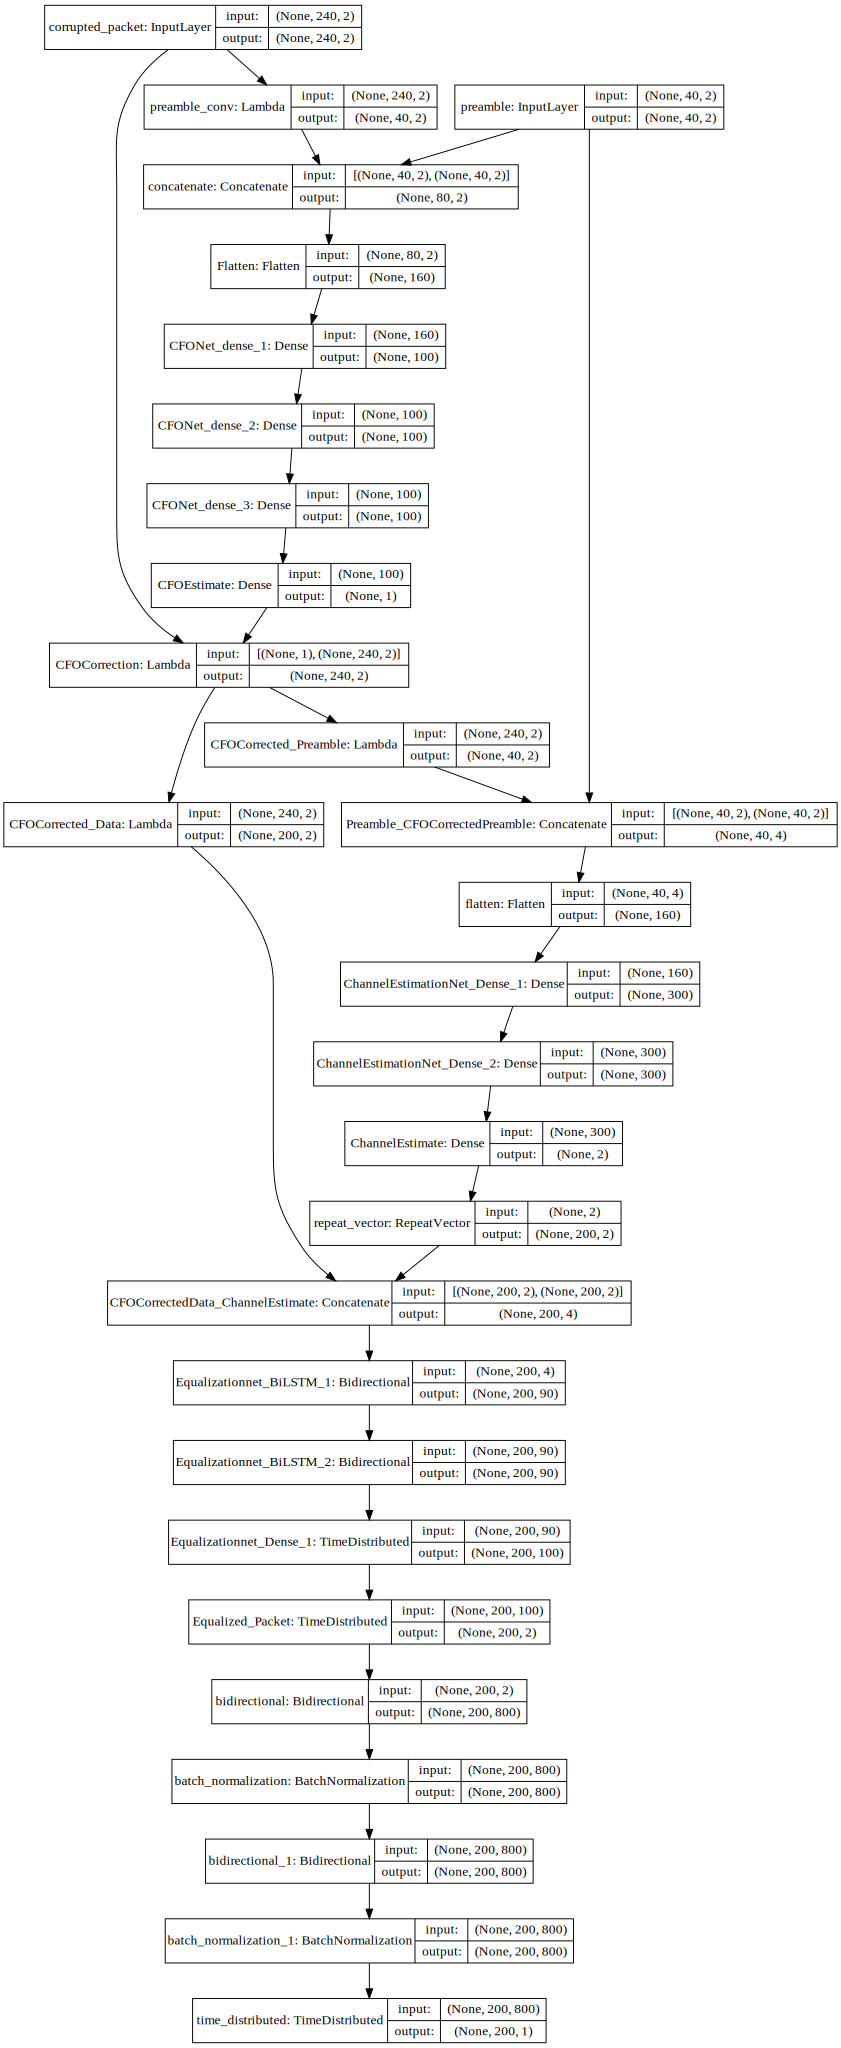

In [7]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Load modular pretrained weights

In [8]:
model.load_weights('../models/cfo_nn_tanh_omgega.hdf5', by_name=True)
model.load_weights('../models/equalization3.hdf5', by_name=True)
model.load_weights('BiGRU_BSC.hdf5', by_name=True)
model.compile(tf.keras.optimizers.Adam(0.00001),'mse')

In [9]:
# history = model.fit_generator(
#     generator=training_generator,
#     steps_per_epoch=100,
#     epochs=5)

## Evaluate with no CFO Effect

In [10]:
class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 10.0, 12.0, 15.0, 17.0, 20.0, 25.0, 40.0]
    NUM_SAMPLES = 1000

In [11]:
baseline = Baseline()

model = tf.keras.models.load_model('../models/end2end_receiver.hdf5',
                                   custom_objects={'PREAMBLE_LEN': PREAMBLE_LEN, 'tf': tf}, compile=False)
                                   
                                   
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    x_test, y_test = next(radio.end2end_data_generator(1/10000, 
                                                       snr, 
                                                       batch_size=Params.NUM_SAMPLES, 
                                                       num_cpus=16, 
                                                       seed=2019))
    Y_test = np.squeeze(y_test[0], -1)  #(batch, 100, 1) to (batch, 100)
    
    # Run Baseline/Neral Receiver
    t1 = time.time()
        
    [preambles, corrupted_packets] = x_test
    preambles = preambles.view(complex)
    convolved_preamble = np.array(corrupted_packets[:, :radio.preamble_len, :]).view(complex)
    convolved_data     = np.array(corrupted_packets[:, radio.preamble_len:, :]).view(complex)
    
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimate = pool.starmap(baseline, [(i, j , k) for i, j, k 
                                                    in zip(convolved_data, convolved_preamble, preambles)])

    t2 = time.time()
    
    predictions, _, _ = model.predict(x_test, 500)
    nn_estimate = np.squeeze(predictions, -1).round()
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    ber, bler       = get_ber_bler(np.array(baseline_estimate), Y_test)
    nn_ber, nn_bler = get_ber_bler(nn_estimate, Y_test)

    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])

SNR_dB = 0.000000
	[Modular]  Ber = 0.44401000 | Bler =1.00000000 - 2.27253s
	[Baseline] Ber = 0.31358500 | Bler =1.00000000 - 8.45572s
SNR_dB = 3.000000
	[Modular]  Ber = 0.31696000 | Bler =1.00000000 - 1.52915s
	[Baseline] Ber = 0.14105500 | Bler =1.00000000 - 8.05099s
SNR_dB = 5.000000
	[Modular]  Ber = 0.16489000 | Bler =0.99900000 - 1.49146s
	[Baseline] Ber = 0.05989500 | Bler =0.91600000 - 7.96034s
SNR_dB = 7.000000
	[Modular]  Ber = 0.04633500 | Bler =0.92600000 - 1.49234s
	[Baseline] Ber = 0.02369500 | Bler =0.70000000 - 7.95117s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00294500 | Bler =0.30500000 - 1.50932s
	[Baseline] Ber = 0.00751000 | Bler =0.46300000 - 7.96546s
SNR_dB = 12.000000
	[Modular]  Ber = 0.00063000 | Bler =0.10000000 - 1.50965s
	[Baseline] Ber = 0.00468000 | Bler =0.37000000 - 8.06240s
SNR_dB = 15.000000
	[Modular]  Ber = 0.00023500 | Bler =0.04700000 - 1.51959s
	[Baseline] Ber = 0.00315000 | Bler =0.31000000 - 8.06869s
SNR_dB = 17.000000
	[Modular]  Ber = 0.000200

In [12]:
np.savetxt('ber_nocfo.txt', ber_logs)
np.savetxt('bler_nocfo.txt', bler_logs)

## Evaluate with CFO Effect

In [13]:
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    x_test, y_test = next(radio.end2end_data_generator(OMEGA_TRAIN, 
                                                       snr, 
                                                       batch_size=Params.NUM_SAMPLES, 
                                                       num_cpus=16, 
                                                       seed=2019))
    Y_test = np.squeeze(y_test[0], -1)  #(batch, 100, 1) to (batch, 100)
    
    # Run Baseline/Neral Receiver
    t1 = time.time()
        
    [preambles, corrupted_packets] = x_test
    preambles = preambles.view(complex)
    convolved_preamble = np.array(corrupted_packets[:, :radio.preamble_len, :]).view(complex)
    convolved_data     = np.array(corrupted_packets[:, radio.preamble_len:, :]).view(complex)
    
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimate = pool.starmap(baseline, [(i, j , k) for i, j, k 
                                                    in zip(convolved_data, convolved_preamble, preambles)])

    t2 = time.time()
    
    predictions, _, _ = model.predict(x_test, 500)
    nn_estimate = np.squeeze(predictions, -1).round()
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    ber, bler       = get_ber_bler(np.array(baseline_estimate), Y_test)
    nn_ber, nn_bler = get_ber_bler(nn_estimate, Y_test)

    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])

SNR_dB = 0.000000
	[Modular]  Ber = 0.44527500 | Bler =1.00000000 - 1.50157s
	[Baseline] Ber = 0.47016500 | Bler =1.00000000 - 7.96942s
SNR_dB = 3.000000
	[Modular]  Ber = 0.31816000 | Bler =1.00000000 - 1.51601s
	[Baseline] Ber = 0.43339000 | Bler =1.00000000 - 7.93774s
SNR_dB = 5.000000
	[Modular]  Ber = 0.17108500 | Bler =0.99900000 - 1.49772s
	[Baseline] Ber = 0.40966000 | Bler =0.99400000 - 7.94886s
SNR_dB = 7.000000
	[Modular]  Ber = 0.05089000 | Bler =0.92800000 - 1.49409s
	[Baseline] Ber = 0.39582500 | Bler =0.96800000 - 8.05085s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00345000 | Bler =0.31600000 - 1.51068s
	[Baseline] Ber = 0.38490000 | Bler =0.93600000 - 7.96551s
SNR_dB = 12.000000
	[Modular]  Ber = 0.00072000 | Bler =0.10400000 - 1.51596s
	[Baseline] Ber = 0.37955500 | Bler =0.91900000 - 7.96857s
SNR_dB = 15.000000
	[Modular]  Ber = 0.00023000 | Bler =0.04600000 - 1.72547s
	[Baseline] Ber = 0.37455000 | Bler =0.90400000 - 8.26109s
SNR_dB = 17.000000
	[Modular]  Ber = 0.000175

In [19]:
np.savetxt('ber_withcfo.txt', ber_logs)
np.savetxt('bler_withcfo.txt', bler_logs)